## Connect google drive


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Nov 11 00:34:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121


## Install Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.24.0


# Checking with random high resolution image


0: 1280x864 14 persons, 1 train, 1 boat, 6 backpacks, 5 handbags, 2 suitcases, 1 surfboard, 1 chair, 224.5ms
Speed: 11.2ms preprocess, 224.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 864)


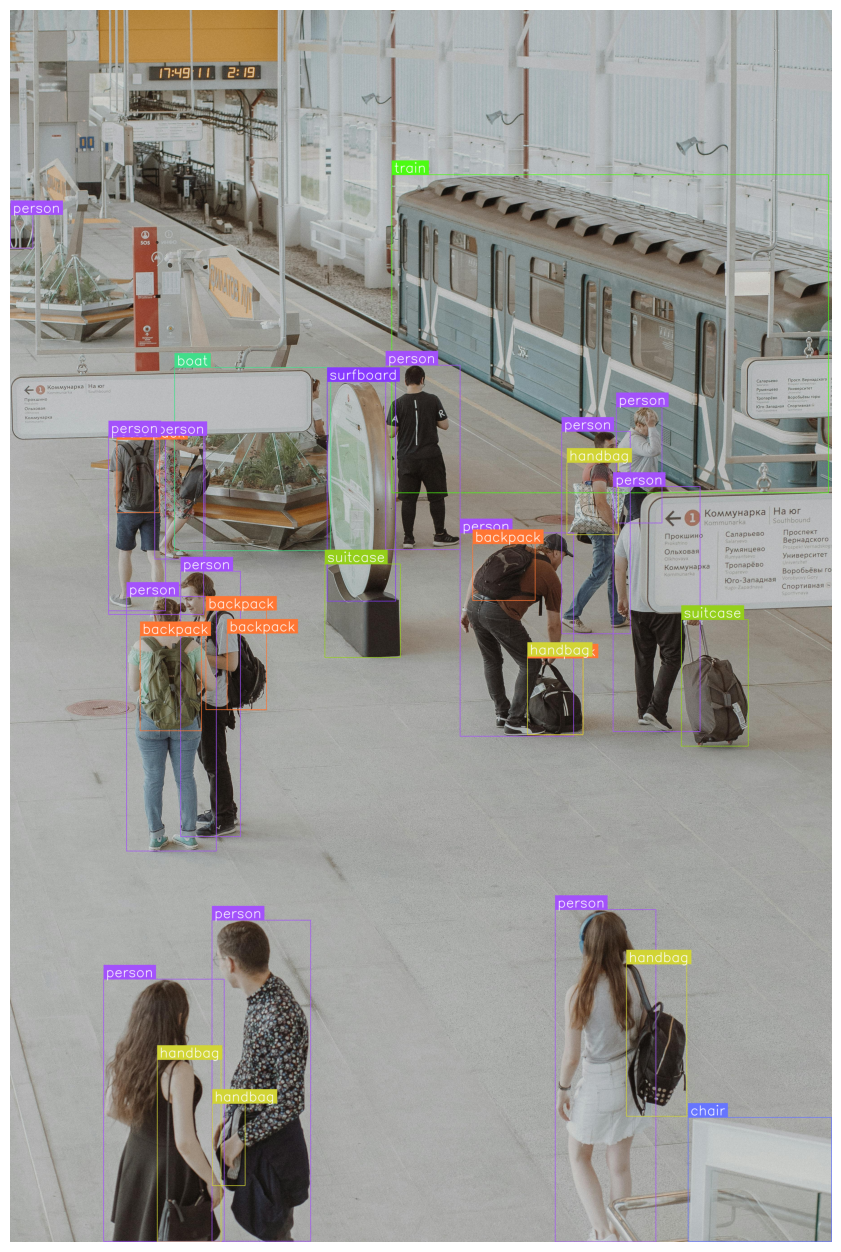

In [ ]:
import cv2
import supervision as sv

# Load the image from the file path
frame_path = '/content/drive/MyDrive/Projects/railway/pexels-fearvi-3848896.jpg'
frame = cv2.imread(frame_path)

# Run detection
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# Annotate
box_annotator = sv.BoxAnnotator(thickness=2)  # Use BoxAnnotator instead of BoundingBoxAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections)

# Display the image
%matplotlib inline
sv.plot_image(frame, (16, 16))


In [ ]:
sv.VideoInfo.from_video_path("/content/drive/MyDrive/Projects/railway/18525547-uhd_3840_2160_30fps (1).mp4")


VideoInfo(width=3840, height=2160, fps=29, total_frames=452)

# Get the first Frame


In [ ]:
import cv2
VIDEO = "/content/drive/MyDrive/Projects/railway/1111.mp4"
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)


True

###  [polygonzone](https://polygonzone.roboflow.com/) :here upload the image , draw polygone and get the polygon zone

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 15.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
from IPython import display
from supervision import Color


# Load the YOLO model
model = YOLO('yolo11x.pt')

# Define the polygon zone for filtering
polygon = np.array([[3836, 2034], [515, 1277], [515, 1277], [414, 1279], [397, 2150], [3831, 2155]])
zone = sv.PolygonZone(polygon=polygon)

# Video information and annotators
video_info = sv.VideoInfo.from_video_path("/content/drive/MyDrive/Projects/railway/18525547-uhd_3840_2160_30fps (1).mp4")
box_annotator = sv.BoundingBoxAnnotator(thickness=4,color=Color(255, 127, 80))
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2,color=Color(0, 0, 0))
zone_annotator = sv.PolygonZoneAnnotator(zone=zone,text_color=Color(255, 255, 255), color=Color(139, 0, 0), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # Run detection
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]  # Filter for a specific class, e.g., class_id == 0

    # Trigger zone and get mask for detections within the zone
    is_in_zone = zone.trigger(detections=detections)

    # Filter detections using the is_in_zone array
    detections_in_zone = detections[is_in_zone]

    # Annotate detections within the zone
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections_in_zone]
    frame = box_annotator.annotate(scene=frame, detections=detections_in_zone)
    frame = label_annotator.annotate(scene=frame, detections=detections_in_zone, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

# Process video
sv.process_video(source_path="/content/drive/MyDrive/Projects/railway/18525547-uhd_3840_2160_30fps (1).mp4", target_path="/content/result.mp4", callback=process_frame)

# Clear output
display.clear_output()
